In [2]:


from scipy.linalg import sqrtm
import numpy as np










In [20]:

import numpy as np
from scipy.linalg import cholesky

def simulate_data_random_cholesky(n, p, beta_star, sigma):
    """
    Generates (X, Y) where:
      - X has shape (n, p)
      - The columns of X have covariance L L^T, for a random lower-triangular L
      - Y = X beta_star + noise, with noise ~ N(0, sigma^2)
    You do NOT provide Sigma directly; it's implicitly defined by the random L L^T.
    """
    # 1) Generate a random lower-triangular matrix L
    #    We add a small positive constant on the diagonal to ensure positivity.
    L = np.tril(np.random.randn(p, p))
    # Make the diagonal entries strictly positive by ensuring each diag entry is >= some small epsilon
    eps_diag = 0.1
    np.fill_diagonal(L, np.abs(np.diag(L)) + eps_diag)
    
    # 2) Generate Z ~ N(0, I_{n x p})
    Z = np.random.randn(n, p)
    
    # 3) Form X = Z @ L^T so that Cov(X) = L L^T
    X = Z @ L.T
    
    # 4) Generate noise for Y
    noise = np.random.randn(n) * sigma
    
    # 5) Y = X beta_star + noise
    Y = X @ beta_star + noise
    
    return X, Y

def simulate_data(n, p, Sigma, beta_star, sigma):
    """
    Generates data X, Y from a linear model with X ~ N(0, Sigma) and noise ~ N(0, sigma^2).
    
    :param n: number of samples
    :param p: dimension of features
    :param Sigma: covariance matrix (p x p)
    :param beta_star: true regression coefficients (p, )
    :param sigma: standard deviation of noise
    :return: (X, Y) each a numpy array
    """
    # 1) Generate i.i.d. normal Z ~ N(0, I)
    Z = np.random.normal(loc=0, scale=1, size=(n, p))
    
    # 2) Get a factor L from Sigma = L L^T (Cholesky)
    L = cholesky(Sigma, lower=True)  # L is lower-triangular
    
    # 3) Produce X with covariance Sigma
    X = Z @ L.T
    X = np.column_stack((np.ones(X.shape[0]), X))
    
    # 4) Generate noise
    eps = np.random.normal(loc=0, scale=sigma, size=n)
    
    # 5) Generate responses
    Y = X @ beta_star + eps
    
    return X, Y



def compute_OLS(X, Y):
    """
    Ordinary Least Squares regression
    """
    # Add a column of ones to X for the intercept
    #X = np.column_stack((np.ones(X.shape[0]), X))
    
    # Calculate the coefficients using the Normal Equation
    beta = np.linalg.inv(X.T @ X) @ X.T @ Y
    
    return beta

def compute_combined_OLS(X, Y, X2, Y2, lambda_=0):
    """
    Ordinary Least Squares regression on two datasets
    """
    # Add a column of ones to X for the intercept
    #X = np.column_stack((np.ones(X.shape[0]), X))
    #X2 = np.column_stack((np.ones(X2.shape[0]), X2))
    # Calculate the coefficients using the Normal Equation
    beta = np.linalg.inv(X.T @ X + lambda_ * X2.T @ X2) @ ( X.T @ Y + lambda_ * X2.T @ Y2)
    
    return beta


X  = np.random.normal(size=(100, 10))

In [ ]:
n, p = 200, 5
beta_star = np.array([1, 1, 2, 0, 0, 3], dtype=float)
sigma = 1.0
L = np.tril(np.random.randn(p, p))
# Make the diagonal entries strictly positive by ensuring each diag entry is >= some small epsilon
eps_diag = 0.1
np.fill_diagonal(L, np.abs(np.diag(L)) + eps_diag)
Sigma = L @ L.T
X, Y = simulate_data(n, p, Sigma, beta_star, sigma)
L2 = np.tril(np.random.randn(p, p))
u = 0.001
Sigma2 = (L + u *L2) @ (L + u * L2).T
eta= np.random.normal(size=(p+1,))
X2, Y2 = simulate_data(n, p, Sigma2, beta_star + u * eta, sigma)
print("X shape:", X.shape)
print("Y shape:", Y.shape)
    
# Empirical covariance of the columns of X
cov_emp = np.cov(X, rowvar=False)
print("Empirical covariance of X:\n", cov_emp)


print(beta_star)




X shape: (200, 6)
Y shape: (200,)
Empirical covariance of X:
 [[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          3.20587428  2.03401886 -0.30483259  0.93409725  1.5804931 ]
 [ 0.          2.03401886  2.26606154 -0.992749   -0.35127078  0.29875681]
 [ 0.         -0.30483259 -0.992749    1.33960557  1.57597267  1.03743571]
 [ 0.          0.93409725 -0.35127078  1.57597267  2.979411    3.26425795]
 [ 0.          1.5804931   0.29875681  1.03743571  3.26425795  5.51942096]]
[1. 1. 2. 0. 0. 3.]
[ 0.82632729  1.04775666  2.09639673  0.15306279 -0.10472919  2.98596611]
[8.63411991e-01 1.01593622e+00 2.06295119e+00 3.98685370e-02
 2.73146818e-03 2.95933199e+00]


In [ ]:
print(compute_OLS(X, Y))
print(compute_combined_OLS(X, Y, X2, Y2, lambda_=0.5))
beta_OLS = compute_OLS(X, Y)
risk = [[0, 0, 0 ] for _ in range(101)]
risk[0][0] = 0
risk[0][1] = np.linalg.norm(beta_OLS - beta_star)**2
Sigma_sqrt = sqrtm(Sigma)
risk[0][2] = np.linalg.norm(Sigma_sqrt @(beta_OLS - beta_star))**2
for i, lambda_ in enumerate(np.arange(0, 1.01, 0.01)):  # Use np.arange to create a sequence from 0 to 1 with step 0.01
    beta_hat = compute_combined_OLS(X, Y, X2, Y2, lambda_=lambda_)
    risk[i][0] = lambda_
    risk[i][1] = np.linalg.norm(beta_hat - beta_star)**2

[ 0.82632729  1.04775666  2.09639673  0.15306279 -0.10472919  2.98596611]
[8.63411991e-01 1.01593622e+00 2.06295119e+00 3.98685370e-02
 2.73146818e-03 2.95933199e+00]


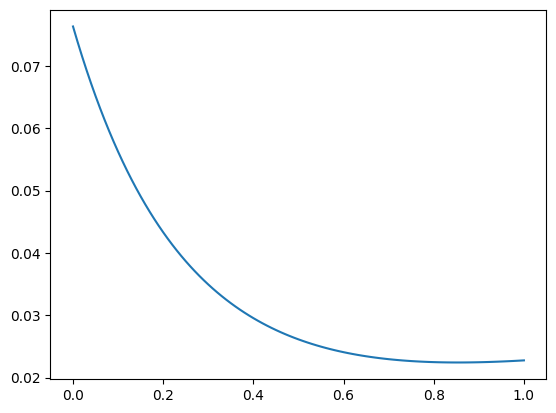

In [26]:
import matplotlib.pyplot as plt

plt.plot([r[0] for r in risk], [r[1] for r in risk])

In [18]:
np.linalg.inv(X.T @ X) @ X.T @ Y

array([0.95738183, 1.2571432 , 3.39650199, 2.27044483, 0.12625419,
       3.00491458])

In [16]:
compute_OLS(X, Y)

LinAlgError: Singular matrix

In [ ]:
n, p = 200, 5
beta_star = np.array([1, 2, 0, 0, 3], dtype=float)
sigma = 1.0
X, Y = simulate_data_random_cholesky(n, p, beta_star, sigma)
print("X shape:", X.shape)
print("Y shape:", Y.shape)
    
# Empirical covariance of the columns of X
cov_emp = np.cov(X, rowvar=False)
print("Empirical covariance of X:\n", cov_emp)
